# **Imports & Fetch**

In [2]:
!pip install "numpy<2.0" "scikit-learn<1.4" "scipy<1.12" "imbalanced-learn<0.13"

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE
from imblearn.pipeline import Pipeline

from matplotlib.lines import Line2D

from IPython.display import display_html

In [4]:
import os
import boto3
import io
import mlflow


from mlflow.models import infer_signature

# conctando com o MinIO 
S3_ENDPOINT_URL = os.getenv("MLFLOW_S3_ENDPOINT_URL", "http://minio:9000")
AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID", "admin")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY", "admin123")
BUCKET = "dados-analise"

s3 = boto3.client(
    "s3",
    endpoint_url=S3_ENDPOINT_URL,
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
)

mlflow.set_tracking_uri(os.getenv("MLFLOW_TRACKING_URI", "http://mlflow:5000"))

print("Conectado no MinIO:", S3_ENDPOINT_URL)



Conectado no MinIO: http://minio:9000


In [7]:
resp = s3.list_objects_v2(Bucket=BUCKET)
for obj in resp.get("Contents", []):
    print(obj["Key"], "-", obj["Size"], "bytes")

objects = resp.get("Contents", [])
if not objects:
    raise RuntimeError("Nenhum dado encontrado")

# Pega todos os cvs enviados, ordena pela datas e usa o ultimo que chegou
latest_obj = sorted(objects, key=lambda o: o["LastModified"])[-1]
latest_key = latest_obj["Key"]

print(latest_key )

obj = s3.get_object(Bucket=BUCKET, Key=latest_key)
conteudo = obj["Body"].read()

df = pd.read_csv(io.BytesIO(conteudo))
df.head()

heart_failure_clinical_records_dataset.csv - 12239 bytes
heart_failure_clinical_records_dataset.csv


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [8]:
# heart_failure_clinical_records = fetch_ucirepo(id=519)

In [9]:
# features = heart_failure_clinical_records.data.features
# targets = heart_failure_clinical_records.data.targets

**Exploratory Data Analysis**

In [10]:
# df = pd.concat([features, targets], axis=1)

In [11]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [16]:
df.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [13]:
df.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

In [14]:
df.isna().any()

age                         False
anaemia                     False
creatinine_phosphokinase    False
diabetes                    False
ejection_fraction           False
high_blood_pressure         False
platelets                   False
serum_creatinine            False
serum_sodium                False
sex                         False
smoking                     False
time                        False
DEATH_EVENT                 False
dtype: bool

base de dados não possui valores nulos.

In [20]:
df = df.rename(columns={"DEATH_EVENT": "death_event"})

**PairPlot**

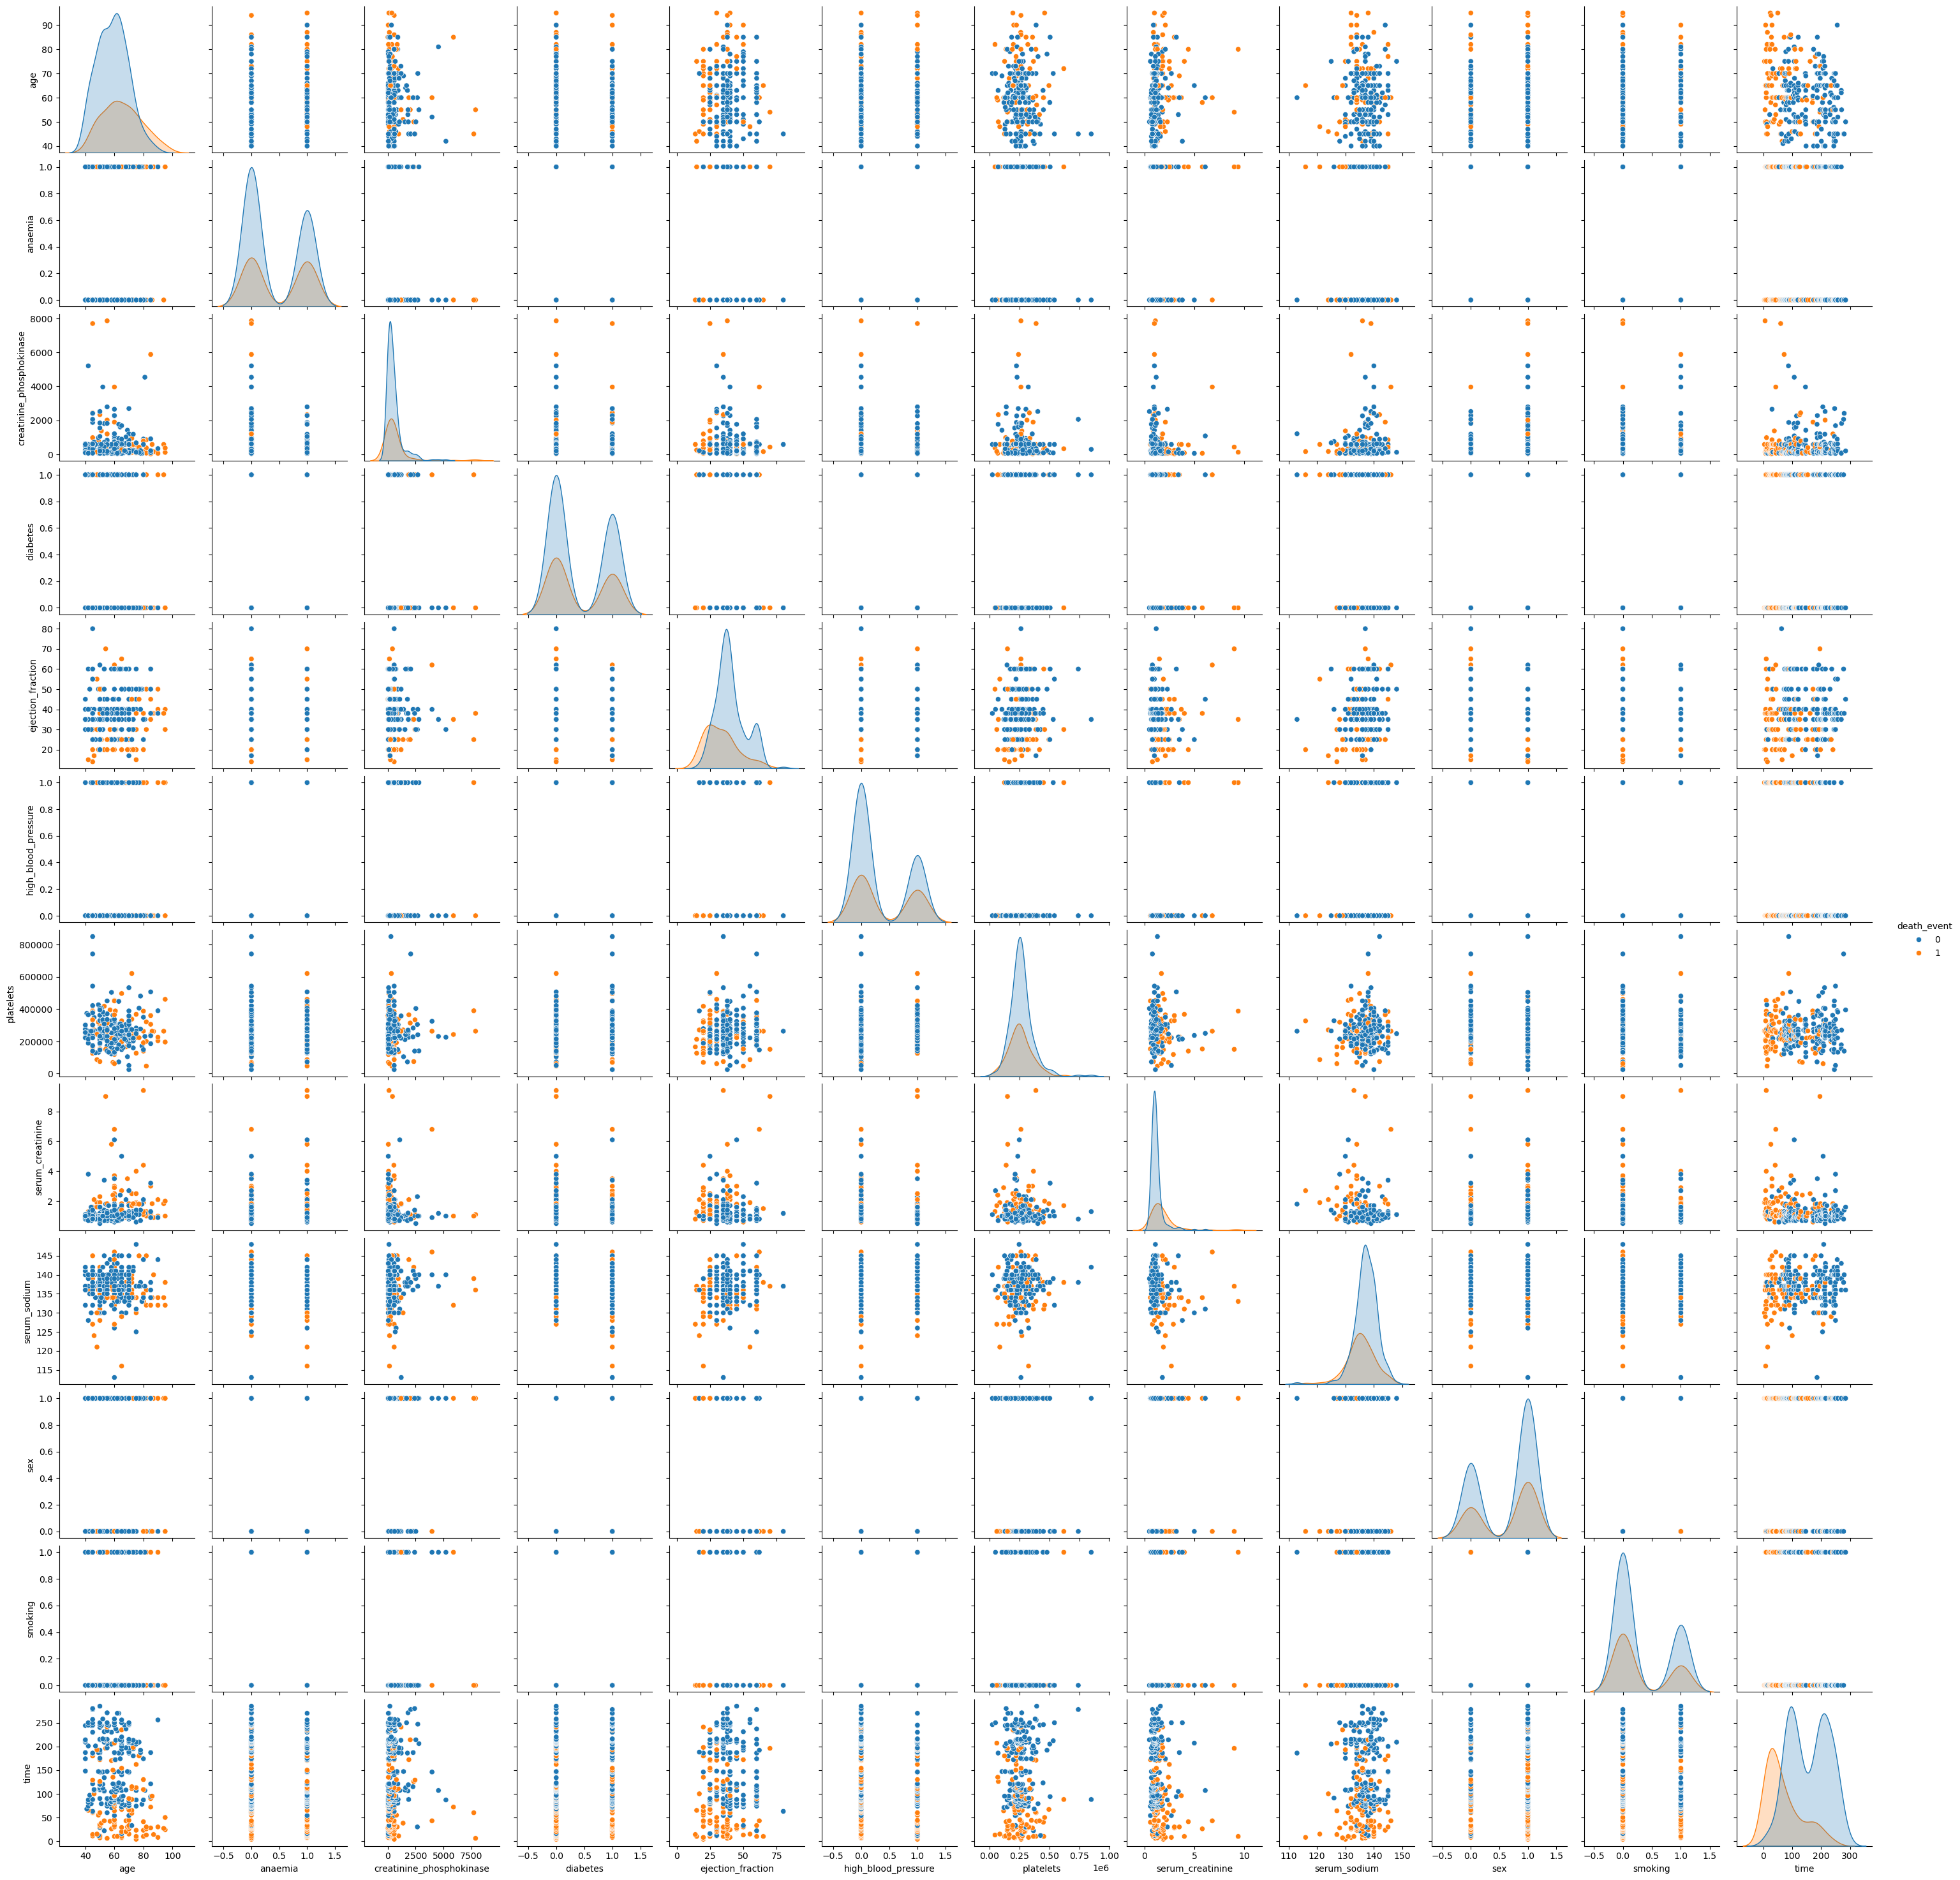

In [21]:
sns.pairplot(df, hue='death_event')

**Conjunto de Dados (X) e Target (y)**

In [22]:
X = df.drop('death_event', axis = 1)
y = df['death_event']

In [24]:
X

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280


In [25]:
y.value_counts()

death_event
0    203
1     96
Name: count, dtype: int64

Os dados estão desbalanceados, 2x a quantidade de pessoas que sobrevivem em relação aos que morrem.

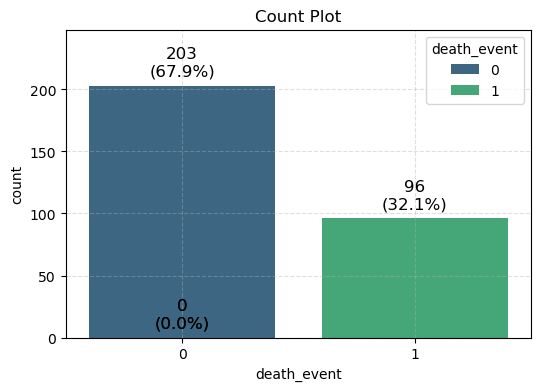

In [26]:
plt.figure(figsize=(6,4))

ax = sns.countplot(
    x='death_event',
    data=df,
    palette='viridis',
    hue=df['death_event']
)


total = len(df)
for p in ax.patches:
    height = p.get_height()
    percentage = f'{100 * height / total:.1f}%'
    ax.annotate(f'{int(height)}\n({percentage})',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=12, color='black',
                xytext=(0, 5), textcoords='offset points')


plt.ylim(0, total * 0.83) # Ajuste conforme necessário
plt.title('Count Plot')
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

**0  = Sobreviveu**
<br>
**1  = Faleceu**

---

# Train Test Split Original

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3 ,random_state=42)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Oversamplers Comparison

**Oversampling** (ou **Undersampling**) se faz necessário pois os dados estão desbalanceados, o que pode ocorrer é o algoritmo não conseguir generalizar os resultados devido ao desbalanceamento do conjunto de treino.

Comparações técnicas para avaliar qual modelo usar x Sem Resampling algum.

Técnica                        | F1-Score Médio  | Desvio Padrão
-----------------------------------------------------------------
Sem Resampling (Baseline)      | 0.7032          | 0.0615
Random OverSampler             | 0.7632          | 0.1015
SMOTE                          | 0.7775          | 0.0522
Borderline SMOTE               | 0.7842          | 0.0284
ADASYN                         | 0.7878          | 0.0692


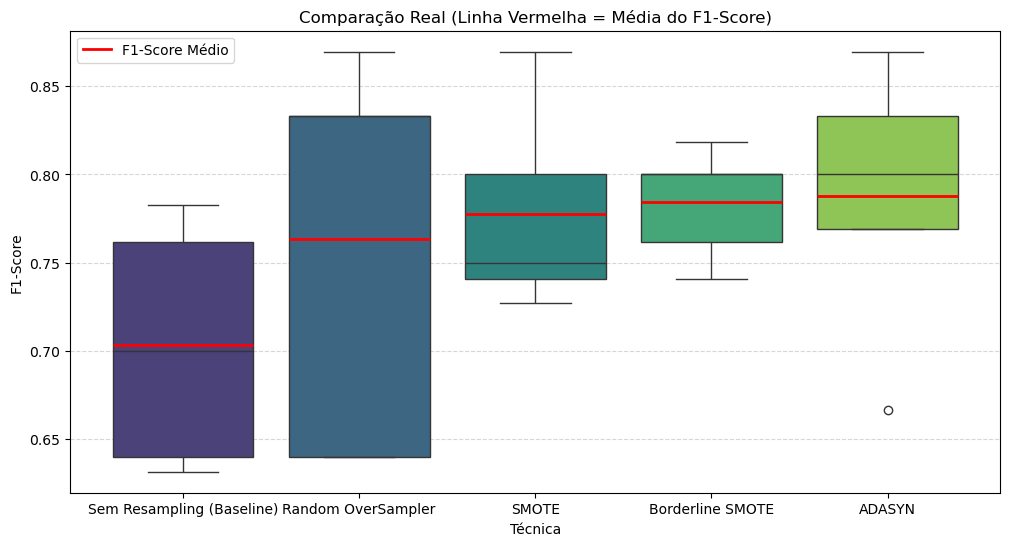

In [30]:
# Se y for um DataFrame, pegamos a série (coluna única) para evitar avisos
if isinstance(y, pd.DataFrame):
    y = y.iloc[:, 0]

# Baixo kn devido ao pequeno tamanho do dataset.
k_neighbors = 3

samplers = {
    "Sem Resampling (Baseline)": None,
    "Random OverSampler": RandomOverSampler(random_state=42),
    "SMOTE": SMOTE(sampling_strategy='minority', k_neighbors=k_neighbors, random_state=42),
    "Borderline SMOTE": BorderlineSMOTE(sampling_strategy='minority', k_neighbors=k_neighbors, random_state=42),
    "ADASYN": ADASYN(sampling_strategy='minority', n_neighbors=k_neighbors, random_state=42)
}

# Modelo fixo para a comparação (com class_weight para ajudar a base)
model = RandomForestClassifier(class_weight='balanced', random_state=42)

# --- 3. Execução da Comparação ---
results = []

# StratifiedKFold é CRUCIAL aqui para manter a proporção de mortes em cada dobra
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print(f"{'Técnica':<30} | {'F1-Score Médio':<15} | {'Desvio Padrão'}")
print("-" * 65)

for name, sampler in samplers.items():
    if sampler is None:
        pipe = Pipeline([('model', model)])
    else:
        pipe = Pipeline([('resampling', sampler), ('model', model)])


    # Avaliamos com F1-Score (melhor que acurácia para desbalanceados)
    scores = cross_val_score(pipe, X_train_scaled, y_train, scoring='f1', cv=cv)

    # Salvamos para o gráfico
    for score in scores:
        results.append({'Técnica': name, 'F1-Score': score})

    print(f"{name:<30} | {scores.mean():.4f}          | {scores.std():.4f}")


# --- 4. Visualização ---
results_df = pd.DataFrame(results)

plt.figure(figsize=(12, 6))

# Definimos a ordem explicitamente para garantir que o loop alinhe corretamente
order = list(samplers.keys())

# Criação do Boxplot
ax = sns.boxplot(data=results_df, x='Técnica', y='F1-Score',
                 palette='viridis', hue='Técnica', order=order)

# --- ADIÇÃO: Linhas de Média ---
# 1. Calcular a média por técnica
means = results_df.groupby('Técnica')['F1-Score'].mean()

# 2. Iterar sobre as categorias e desenhar a linha
# O eixo X do seaborn numera as categorias como 0, 1, 2, 3... na ordem definida
for i, technique in enumerate(order):
    mean_val = means[technique]

    # Desenha a linha horizontal vermelha
    # xmin/xmax define a largura da linha (i +/- 0.4 cobre a largura da caixa)
    plt.hlines(y=mean_val, xmin=i - 0.4, xmax=i + 0.4,
               colors='red', linewidth=2, zorder=10)

# Título e Grid
plt.title('Comparação Real (Linha Vermelha = Média do F1-Score)')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)


legend_elements = [Line2D([0], [0], color='red', lw=2, label='F1-Score Médio')]
# Adiciona à legenda existente ou cria uma nova
plt.legend(handles=legend_elements, loc='best')

plt.show()




# Pontos de possivel melhora:
#       nesse dataset nao eh preciso se preocupar tanto com memory leakage
#       , mas para evitar isso, em vez de usarmos o scaler antes, colocamos
#       ele dentro do pipeline e passamos apenas o x_train e y_train para o
#       scores.
#
#       Da forma que esta, as dobras do Kfold ja conhecem a media global.

* O Stratified K-fold foi usado em vez do Kfold devido ao SKFold obedecer ao balanceamento dos dados em cada dobra, enquanto o Kfold não.

Vamos escolher o metodo de OverSampling baseado no maior F1 score, mas que tenha a menor taxa de variacao media, queremos manter consistencia dos dados para melhores decisoes dos modelos de predicao seguintes.

 Anlisando os resultados:
<br>
1.   Sem Resampling
2.   Random OverSampler
3.   SMOTE
4.   Borderline SMOTE
5.   ADASYN




**Sem Resampling:** manter o dataset original; tem uma variação alta de f1-score, mas apresentou o maior f1-score médio no final.

**Veredito: RUIM.**

<br>

---
<br>

**Random Oversampler:** repõe casos aleatórios com outro de menor classe, o que termina por dar um "boost" na menor classe mesmo que AS VEZES troque "6 por 1/2 dúzia".

Apresentou F1-Score maior do que o Sem Resample, mas menor que os outros metodos, alem disso variou mais do que o base.

**Veredito: MUITO RUIM**

<br>

---
<br>

**SMOTE:** Synthetic Minority Over-sampling, o SMOTE gera vizin hos sintéticos novos no meio do caminho entre o k-vizinhos mais próximos, se repetindo até o dataset ser balanceado.

Apresentou um F1-Score médio maior, e teve uma variação bem menor que o Sem Resampling ou Random Oversample, ou seja, é mais estável, que é o que estamos procurando.

**Veredito: BOM**

<br>

---
<br>

**Borderline SMOTE:** funciona da mesma maneira que o SMOTE, mas em vez de criar novas instancias baseados no ponto de encontro(meio) dos k-vizinhos, ele cria os novos pontos nas bordas das decisões, o que ajuda a conter os que são mal-classificados pelo SMOTE comum.

Se deu melhor que o SMOTE simples, com o F1-Score um pouco maior,teve a menor variacao dentre os concorrentes(ou seja, O MAIS ESTAVEL).

**Veredito: MELHOR <------------------------------------------------**

<br>

---
<br>

**ADASYN:** Adaptive Synthetic Sampling coloca um peso nos calculos dos vizinhos, esse peso eh maior para aqueles que sao computacionalmente mais dificeis de computar (quando uma entrada está muito perto de multiplos vizinhos de classe diferente da dele), ele começa a gerar novos dados para que o que antes era difícil, fica mais fácil, ele não é tão rígido quando o SMOTE e por isso, é normal as classes ficarem levemente desbalanceada (~5%).

Apresentou O Maior F1-Score mesmo que por pouco, obeteve uma taxa aceitavel de variacao, mas introduziu Outliers.

**Veredito: OK**

# Divisao em 3 Datasets e aplicação das tecnicas de Oversampling:
- SMOTE
- Borderline SMOTE
- ADASYN

In [31]:
df_smote = df
df_bsmote = df
df_adasyn = df

In [32]:
# SMOTE
print(f"Tamanho antes, df_smote: {df_smote.shape}")

X_temp = df_smote.drop(columns=['death_event'])
y_temp = df_smote['death_event']

smote = SMOTE(sampling_strategy='minority', k_neighbors=3, random_state=42)

X_res, y_res = smote.fit_resample(X_temp, y_temp)

df_smote = pd.concat([
    pd.DataFrame(X_res, columns=X_temp.columns),
    pd.Series(y_res, name='death_event')
], axis=1)

print(f"Novo tamanho, df_smote: {df_smote.shape}")

df_smote['death_event'].value_counts()

Tamanho antes, df_smote: (299, 13)
Novo tamanho, df_smote: (406, 13)


death_event
1    203
0    203
Name: count, dtype: int64

In [33]:
# Borderline SMOTE
print(f"Tamanho antes, df_bsmote: {df_bsmote.shape}")

X_temp = df_bsmote.drop(columns=['death_event'])
y_temp = df_bsmote['death_event']

bsmote = BorderlineSMOTE(sampling_strategy='minority', k_neighbors=3, random_state=42)

X_res, y_res = bsmote.fit_resample(X_temp, y_temp)

df_bsmote = pd.concat([
    pd.DataFrame(X_res, columns=X_temp.columns),
    pd.Series(y_res, name='death_event')
], axis=1)

print(f"Novo tamanho, df_bsmote: {df_bsmote.shape}")

df_bsmote['death_event'].value_counts()

Tamanho antes, df_bsmote: (299, 13)
Novo tamanho, df_bsmote: (406, 13)


death_event
1    203
0    203
Name: count, dtype: int64

In [34]:
# ADASYN
print(f"Tamanho antes, df_adasyn: {df_adasyn.shape}")

X_temp = df_adasyn.drop(columns=['death_event'])
y_temp = df_adasyn['death_event']

adasyn = ADASYN(sampling_strategy='minority', n_neighbors=3, random_state=42)

X_res, y_res = adasyn.fit_resample(X_temp, y_temp)

df_adasyn = pd.concat([
    pd.DataFrame(X_res, columns=X_temp.columns),
    pd.Series(y_res, name='death_event')
], axis=1)

print(f"Novo tamanho, df_adasyn: {df_adasyn.shape}")

df_adasyn['death_event'].value_counts()

Tamanho antes, df_adasyn: (299, 13)
Novo tamanho, df_adasyn: (427, 13)


death_event
1    224
0    203
Name: count, dtype: int64

# Train Test Split Divisoes

Divisao dos dados features(X), target(y) das divisões;

In [35]:
X_smote = df_smote.drop('death_event', axis = 1)
y_smote = df_smote['death_event']

X_bsmote = df_bsmote.drop('death_event', axis = 1)
y_bsmote = df_bsmote['death_event']

X_adasyn = df_adasyn.drop('death_event', axis = 1)
y_adasyn = df_adasyn['death_event']

In [36]:
scaler = StandardScaler()

X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size=0.3 ,random_state=42)
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_test_smote_scaled = scaler.transform(X_test_smote)

X_train_bsmote, X_test_bsmote, y_train_bsmote, y_test_bsmote = train_test_split(X_bsmote, y_bsmote, test_size=0.3 ,random_state=42)
X_train_bsmote_scaled = scaler.fit_transform(X_train_bsmote)
X_test_bsmote_scaled = scaler.transform(X_test_bsmote)

X_train_adasyn, X_test_adasyn, y_train_adasyn, y_test_adasyn = train_test_split(X_adasyn, y_adasyn, test_size=0.3 ,random_state=42)
X_train_adasyn_scaled = scaler.fit_transform(X_train_adasyn)
X_test_adasyn_scaled = scaler.transform(X_test_adasyn)

# KNN Classifier

Metodo do cotovelo para testar o numero de k-neighbors ideal

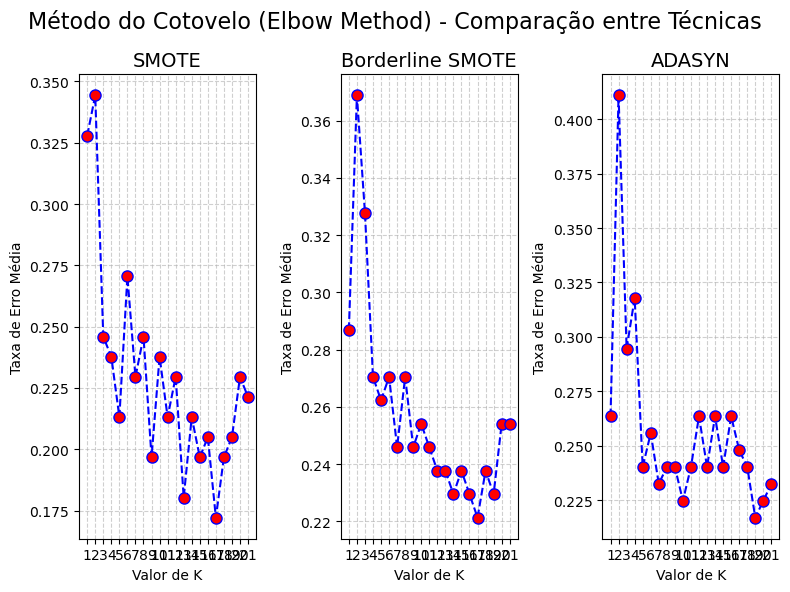

In [37]:
datasets = {
    "SMOTE": (X_train_smote_scaled, y_train_smote, X_test_smote_scaled, y_test_smote),
    "Borderline SMOTE": (X_train_bsmote_scaled, y_train_bsmote, X_test_bsmote_scaled, y_test_bsmote),
    "ADASYN": (X_train_adasyn_scaled, y_train_adasyn, X_test_adasyn_scaled, y_test_adasyn)
}


k_range = range(1, 22)
metrics = {}


for name, (X_train, y_train, X_test, y_test) in datasets.items():
    error_rates = []


    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        pred_i = knn.predict(X_test)
        error_rates.append(np.mean(pred_i != y_test))

    metrics[name] = error_rates


fig, axes = plt.subplots(1, 3, figsize=(8, 6))
fig.suptitle('Método do Cotovelo (Elbow Method) - Comparação entre Técnicas', fontsize=16)

for ax, (name, errors) in zip(axes, metrics.items()):
    ax.plot(k_range, errors, color='blue', linestyle='dashed', marker='o',
             markerfacecolor='red', markersize=8)
    ax.set_title(f'{name}', fontsize=14)
    ax.set_xlabel('Valor de K')
    ax.set_ylabel('Taxa de Erro Média')
    ax.set_xticks(k_range)
    ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

Usaremos K = 3, pois foi o que usamos na comaração original.

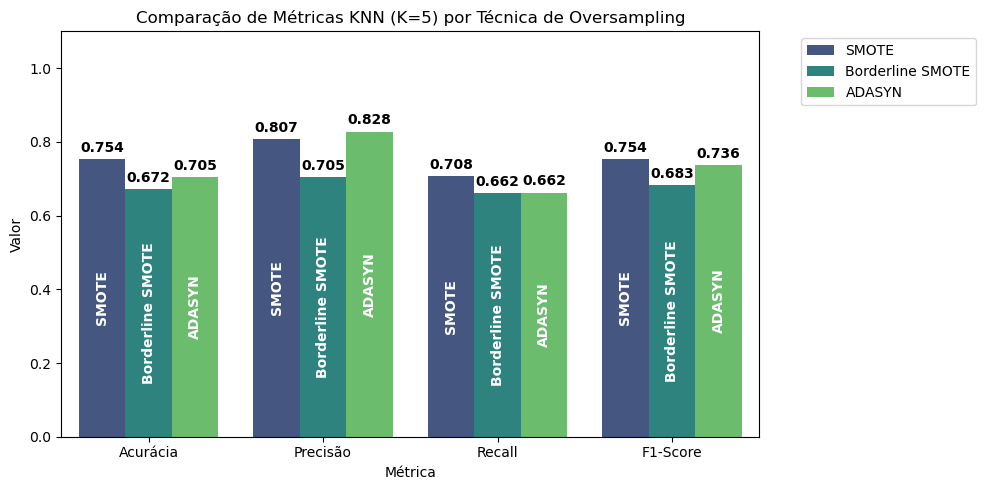

,Tecnica,Acurácia,Precisão,Recall,F1-Score
0,SMOTE,0.754098,0.807018,0.707692,0.754098
1,Borderline SMOTE,0.672131,0.704918,0.661538,0.682540
2,ADASYN,0.705426,0.828125,0.662500,0.736111


In [38]:
knn = KNeighborsClassifier(n_neighbors=3)

# 2. Dicionário agrupando os dados para o loop
# (Assumindo que as variáveis foram criadas nas etapas anteriores)
datasets_dict = {
    "SMOTE": (X_train_smote_scaled, y_train_smote, X_test_smote_scaled, y_test_smote),
    "Borderline SMOTE": (X_train_bsmote_scaled, y_train_bsmote, X_test_bsmote_scaled, y_test_bsmote),
    "ADASYN": (X_train_adasyn_scaled, y_train_adasyn, X_test_adasyn_scaled, y_test_adasyn)
}


results_list_knn = []

# 3. Pipeline de Treino e Avaliação
for name, (X_train, y_train, X_test, y_test) in datasets_dict.items():
    # Treino
    knn.fit(X_train, y_train)

    # Predição
    y_pred_knn = knn.predict(X_test)

    # Coleta de Métricas
    metrics = {
        "Tecnica": name,
        "Acurácia": accuracy_score(y_test, y_pred_knn),
        "Precisão": precision_score(y_test, y_pred_knn),
        "Recall": recall_score(y_test, y_pred_knn),
        "F1-Score": f1_score(y_test, y_pred_knn)
    }
    results_list_knn.append(metrics)

# 4. Exibição Final em DataFrame
df_results_knn = pd.DataFrame(results_list_knn)

plt.figure(figsize=(10, 5))

# Transformando o DF para formato longo para facilitar o plot agrupado
df_melted_knn = df_results_knn.melt(id_vars="Tecnica", var_name="Métrica", value_name="Valor")

ordem_tecnicas = list(datasets_dict.keys())

ax_knn = sns.barplot(data=df_melted_knn, x="Métrica", y="Valor", hue="Tecnica", palette="viridis")
for i, container in enumerate(ax_knn.containers):
    # 1. Rótulo do Valor (Topo, Preto)
    ax_knn.bar_label(
        container,
        fmt='%.3f',
        padding=3,
        fontsize=10,
        color='black',
        weight='bold'
    )

    if i < len(ordem_tecnicas):
        nome_tecnica = ordem_tecnicas[i]

        labels_internos = [nome_tecnica] * len(container)

        ax_knn.bar_label(
            container,
            labels=labels_internos,
            label_type='center',  # Força para o centro da barra
            rotation=90,          # Rotação vertical
            color='white',
            fontsize=10,
            weight='bold'
        )

plt.title("Comparação de Métricas KNN (K=5) por Técnica de Oversampling")
plt.ylim(0, 1.1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Mostra a tabela completa
df_results_knn

# Decision Tree

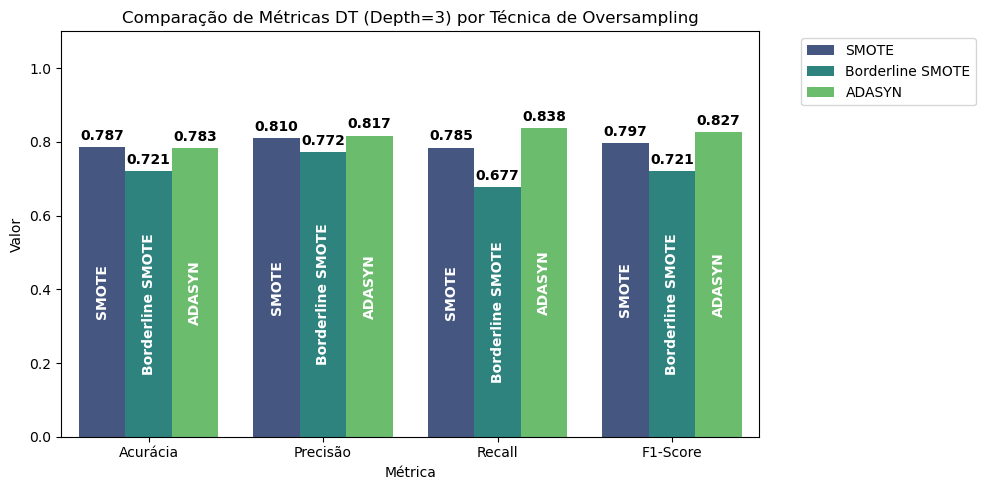

,Tecnica,Acurácia,Precisão,Recall,F1-Score
0,SMOTE,0.786885,0.809524,0.784615,0.796875
1,Borderline SMOTE,0.721311,0.771930,0.676923,0.721311
2,ADASYN,0.782946,0.817073,0.837500,0.827160


In [39]:
dt = DecisionTreeClassifier(max_depth=3, random_state=42)

# 2. Dicionário agrupando os dados para o loop
# (Assumindo que as variáveis foram criadas nas etapas anteriores)
datasets_dict = {
    "SMOTE": (X_train_smote_scaled, y_train_smote, X_test_smote_scaled, y_test_smote),
    "Borderline SMOTE": (X_train_bsmote_scaled, y_train_bsmote, X_test_bsmote_scaled, y_test_bsmote),
    "ADASYN": (X_train_adasyn_scaled, y_train_adasyn, X_test_adasyn_scaled, y_test_adasyn)
}

results_list_dt = []

# 3. Pipeline de Treino e Avaliação
for name, (X_train, y_train, X_test, y_test) in datasets_dict.items():
    # Treino
    dt.fit(X_train, y_train)

    # Predição
    y_pred_dt = dt.predict(X_test)

    # Coleta de Métricas
    metrics = {
        "Tecnica": name,
        "Acurácia": accuracy_score(y_test, y_pred_dt),
        "Precisão": precision_score(y_test, y_pred_dt),
        "Recall": recall_score(y_test, y_pred_dt),
        "F1-Score": f1_score(y_test, y_pred_dt)
    }
    results_list_dt.append(metrics)

# 4. Exibição Final em DataFrame
df_results_dt = pd.DataFrame(results_list_dt)

plt.figure(figsize=(10, 5))
# Transformando o DF para formato longo para facilitar o plot agrupado
df_melted_dt = df_results_dt.melt(id_vars="Tecnica", var_name="Métrica", value_name="Valor")

ordem_tecnicas = list(datasets_dict.keys())

ax_dt = sns.barplot(data=df_melted_dt, x="Métrica", y="Valor", hue="Tecnica", palette="viridis")
for i, container in enumerate(ax_dt.containers):
    # 1. Rótulo do Valor (Topo, Preto)
    ax_dt.bar_label(
        container,
        fmt='%.3f',
        padding=3,
        fontsize=10,
        color='black',
        weight='bold'
    )

    if i < len(ordem_tecnicas):
        nome_tecnica = ordem_tecnicas[i]

        labels_internos = [nome_tecnica] * len(container)

        ax_dt.bar_label(
            container,
            labels=labels_internos,
            label_type='center',  # Força para o centro da barra
            rotation=90,          # Rotação vertical
            color='white',
            fontsize=10,
            weight='bold'
        )

plt.title("Comparação de Métricas DT (Depth=3) por Técnica de Oversampling")
plt.ylim(0, 1.1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Mostra a tabela completa
df_results_dt

# Random Forest

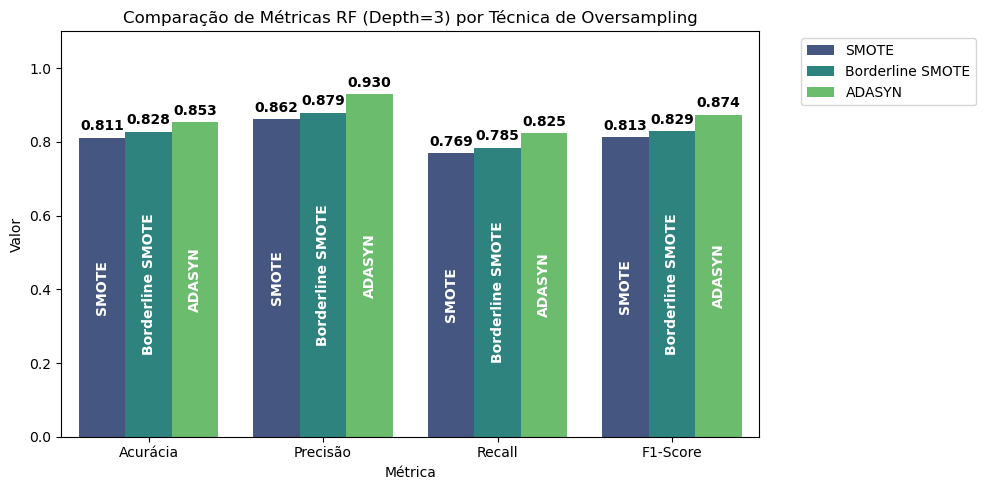

,Tecnica,Acurácia,Precisão,Recall,F1-Score
0,SMOTE,0.811475,0.862069,0.769231,0.813008
1,Borderline SMOTE,0.827869,0.879310,0.784615,0.829268
2,ADASYN,0.852713,0.929577,0.825000,0.874172


In [40]:
rf = RandomForestClassifier(max_depth=3, random_state=42)

# 2. Dicionário agrupando os dados para o loop
# (Assumindo que as variáveis foram criadas nas etapas anteriores)
datasets_dict = {
    "SMOTE": (X_train_smote_scaled, y_train_smote, X_test_smote_scaled, y_test_smote),
    "Borderline SMOTE": (X_train_bsmote_scaled, y_train_bsmote, X_test_bsmote_scaled, y_test_bsmote),
    "ADASYN": (X_train_adasyn_scaled, y_train_adasyn, X_test_adasyn_scaled, y_test_adasyn)
}

results_list_rf = []


# 3. Pipeline de Treino e Avaliação
for name, (X_train, y_train, X_test, y_test) in datasets_dict.items():
    # Treino
    rf.fit(X_train, y_train)

    # Predição
    y_pred_rf = rf.predict(X_test)

    # Coleta de Métricas
    metrics = {
        "Tecnica": name,
        "Acurácia": accuracy_score(y_test, y_pred_rf),
        "Precisão": precision_score(y_test, y_pred_rf),
        "Recall": recall_score(y_test, y_pred_rf),
        "F1-Score": f1_score(y_test, y_pred_rf)
    }
    results_list_rf.append(metrics)


# 4. Exibição Final em DataFrame
df_results_rf = pd.DataFrame(results_list_rf)

plt.figure(figsize=(10, 5))
# Transformando o DF para formato longo para facilitar o plot agrupado
df_melted_rf = df_results_rf.melt(id_vars="Tecnica", var_name="Métrica", value_name="Valor")

ordem_tecnicas = list(datasets_dict.keys())

ax_rf = sns.barplot(data=df_melted_rf, x="Métrica", y="Valor", hue="Tecnica", palette="viridis")
for i, container in enumerate(ax_rf.containers):
    # 1. Rótulo do Valor (Topo, Preto)
    ax_rf.bar_label(
        container,
        fmt='%.3f',
        padding=3,
        fontsize=10,
        color='black',
        weight='bold'
    )

    if i < len(ordem_tecnicas):
        nome_tecnica = ordem_tecnicas[i]

        labels_internos = [nome_tecnica] * len(container)

        ax_rf.bar_label(
            container,
            labels=labels_internos,
            label_type='center',  # Força para o centro da barra
            rotation=90,          # Rotação vertical
            color='white',
            fontsize=10,
            weight='bold'
        )

plt.title("Comparação de Métricas RF (Depth=3) por Técnica de Oversampling")
plt.ylim(0, 1.1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Mostra a tabela completa
df_results_rf

#Ensemble Learning

Voting soft costuma funcionar melhor com datasets menores.

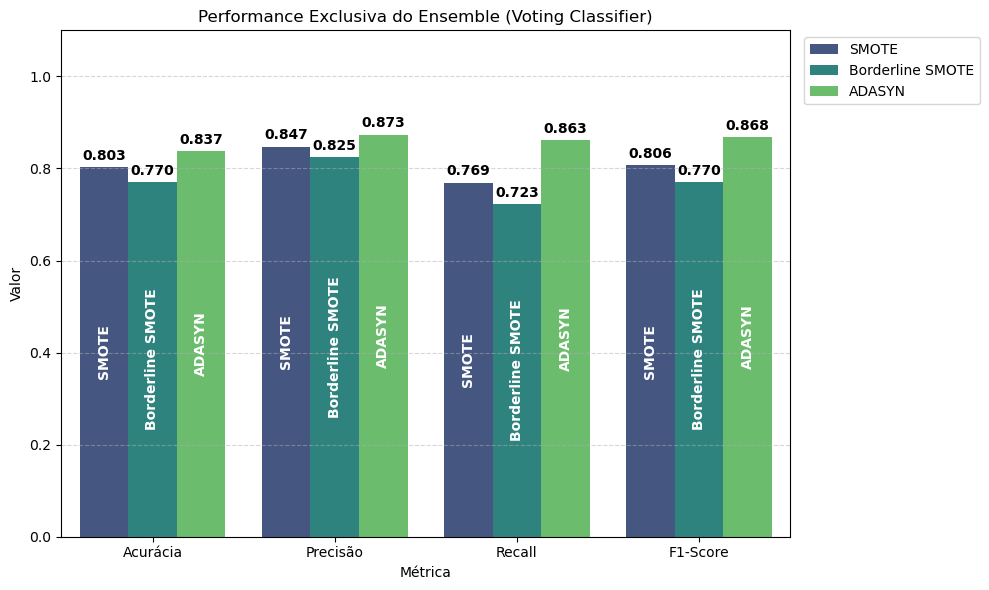

,Tecnica,Acurácia,Precisão,Recall,F1-Score
0,SMOTE,0.803279,0.847458,0.769231,0.806452
1,Borderline SMOTE,0.770492,0.824561,0.723077,0.770492
2,ADASYN,0.837209,0.873418,0.862500,0.867925


In [41]:
ensemble = VotingClassifier(
    estimators=[('KNN', knn), ('Decision Tree', dt), ('Random Forest', rf)],
    voting='soft'
)

# 3. Dicionário de Datasets
datasets_dict = {
    "SMOTE": (X_train_smote_scaled, y_train_smote, X_test_smote_scaled, y_test_smote),
    "Borderline SMOTE": (X_train_bsmote_scaled, y_train_bsmote, X_test_bsmote_scaled, y_test_bsmote),
    "ADASYN": (X_train_adasyn_scaled, y_train_adasyn, X_test_adasyn_scaled, y_test_adasyn)
}

results_ensemble_only = []

# 4. Loop exclusivo para o Ensemble
for name, (X_train, y_train, X_test, y_test) in datasets_dict.items():

    # Treina o Ensemble (ele treina os 3 modelos internos automaticamente)
    ensemble.fit(X_train, y_train)

    # Predição
    y_pred_el = ensemble.predict(X_test)

    # Métricas
    metrics = {
        "Tecnica": name,
        "Acurácia": accuracy_score(y_test, y_pred_el),
        "Precisão": precision_score(y_test, y_pred_el),
        "Recall": recall_score(y_test, y_pred_el),
        "F1-Score": f1_score(y_test, y_pred_el)
    }
    results_ensemble_only.append(metrics)

# 5. Visualização
df_results_ensemble = pd.DataFrame(results_ensemble_only)

plt.figure(figsize=(10, 6))
# Derreter o dataframe para plotar as 3 métricas juntas
df_melted_ensemble = df_results_ensemble.melt(id_vars="Tecnica", var_name="Métrica", value_name="Valor")

ordem_tecnicas = list(datasets_dict.keys())

ax_ensemble = sns.barplot(data=df_melted_ensemble, x="Métrica", y="Valor", hue="Tecnica", palette="viridis")
for i, container in enumerate(ax_ensemble.containers):
    # 1. Rótulo do Valor (Topo, Preto)
    ax_ensemble.bar_label(
        container,
        fmt='%.3f',
        padding=3,
        fontsize=10,
        color='black',
        weight='bold'
    )

    if i < len(ordem_tecnicas):
        nome_tecnica = ordem_tecnicas[i]

        labels_internos = [nome_tecnica] * len(container)

        ax_ensemble.bar_label(
            container,
            labels=labels_internos,
            label_type='center',  # Força para o centro da barra
            rotation=90,          # Rotação vertical
            color='white',
            fontsize=10,
            weight='bold'
        )

plt.title("Performance Exclusiva do Ensemble (Voting Classifier)")
plt.ylim(0, 1.1)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Exibe tabela
df_results_ensemble

# Overview

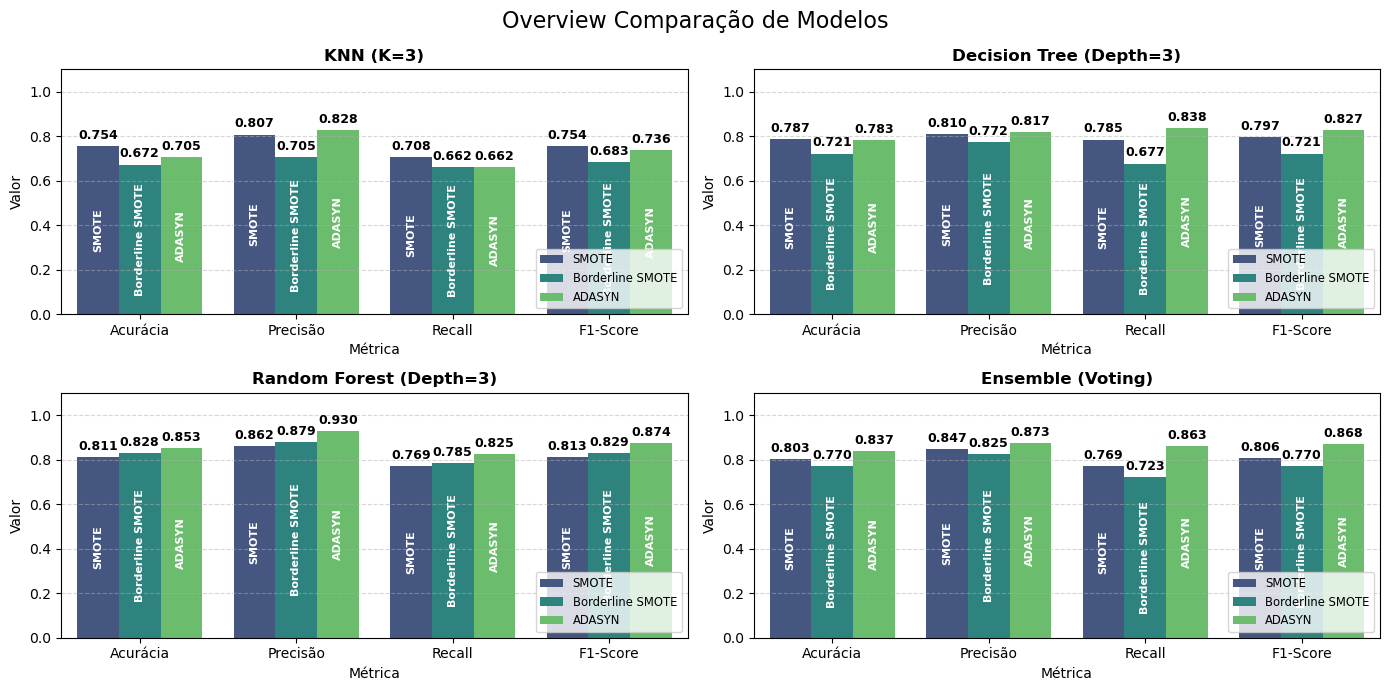

,Tecnica,Acurácia,Precisão,Recall,F1-Score
0,SMOTE,0.754,0.807,0.708,0.754
1,Borderline SMOTE,0.672,0.705,0.662,0.683
2,ADASYN,0.705,0.828,0.662,0.736
,Tecnica,Acurácia,Precisão,Recall,F1-Score
0,SMOTE,0.787,0.810,0.785,0.797
1,Borderline SMOTE,0.721,0.772,0.677,0.721
2,ADASYN,0.783,0.817,0.838,0.827
,Tecnica,Acurácia,Precisão,Recall,F1-Score
0,SMOTE,0.811,0.862,0.769,0.813
1,Borderline SMOTE,0.828,0.879,0.785,0.829


In [42]:
plot_results = [
    ("KNN (K=3)", df_melted_knn),
    ("Decision Tree (Depth=3)", df_melted_dt),
    ("Random Forest (Depth=3)", df_melted_rf),
    ("Ensemble (Voting)", df_melted_ensemble)
]

fig, axes = plt.subplots(2, 2, figsize=(14, 7))
axes = axes.flatten()

for i, (titulo, melted_df) in enumerate(plot_results):
    ax = axes[i]

    sns.barplot(
        data=melted_df,
        x="Métrica",
        y="Valor",
        hue="Tecnica",
        palette="viridis",
        ax=ax
    )

    handles, labels = ax.get_legend_handles_labels()

    for j, container in enumerate(ax.containers):
        # 1. Rótulo do Valor (Topo, Preto)
        ax.bar_label(
            container,
            fmt='%.3f',
            padding=3,
            fontsize=9,
            color='black',
            weight='bold'
        )

        # 2. Rótulo da Técnica (Centro, Branco, 90 graus)
        # Verifica se existe um label correspondente para evitar erros de índice
        if j < len(labels):
            nome_tecnica = labels[j]
            labels_internos = [nome_tecnica] * len(container)

            ax.bar_label(
                container,
                labels=labels_internos,
                label_type='center',  # Força para o centro da barra
                rotation=90,          # Rotação vertical
                color='white',
                fontsize=8,           # Fonte um pouco menor para caber
                weight='bold'
            )

    ax.set_title(titulo, fontsize=12, fontweight='bold')
    ax.set_ylim(0, 1.1)
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.legend(loc='lower right', fontsize='small')

plt.suptitle("Overview Comparação de Modelos", fontsize=16)
plt.tight_layout()
plt.show()

def display_side_by_side(dfs_dict):
    """Exibe dataframes lado a lado usando HTML/CSS e formatação precisa"""
    html_str = '<div style="display: flex; flex-wrap: wrap; gap: 10px;">'

    for titulo, df in dfs_dict.items():
        # Aplica a formatação de 3 casas decimais APENAS para a exibição HTML
        # O método .style.format("{:.3f}") garante que 0.5 vire 0.500
        styler = df.style.format("{:.3f}", subset=["Acurácia", "Precisão", "Recall", "F1-Score"]) \
                         .set_table_attributes('class="table table-striped"') \
                         .set_caption(titulo)

        # Converte o Styler para HTML
        html_str += f'''
        <div style="flex: 1; min-width: 250px; border: 1px solid #ddd; padding: 5px;">
            {styler.to_html()}
        </div>
        '''
    html_str += '</div>'
    display_html(html_str, raw=True)

# Organizando os dataframes
dataframes_para_exibir = {
    "KNN (K=3)": df_results_knn,
    "Decision Tree": df_results_dt,
    "Random Forest": df_results_rf,
    "Ensemble": df_results_ensemble
}

# Chamada da função
display_side_by_side(dataframes_para_exibir)